# Run experiments at NSLS-II

Here, we demonstrate the example code to run the fly scan and grid scan experiment at the NSLS-II.

## Simulated motors and detectors

To demonstrate the example, we set up some simulated motors and detectors for better description. During the beamtime, these objects will be connected to the real devices.

In [1]:
import tomography.sim as sim

# An area detector behind the sample
detector = sim.FakeAreaDetector(name="image")
# A motor to control the vertical position of the sample stage
motor_y = sim.SynAxis(name="y")
# A motor to control the horizontal position of the sample stage
motor_x = sim.SynAxis(name="x")
# A motor to control the orientaion of the sample stage
motor_phi = sim.SynAxis(name="phi")
# A fast shutter
shutter = sim.SynSignal(name="shutter")

## Fly scan

A fly scan is to move to a position in the motor positions space, start the movement of a fly motor and take light images for specific times during the non-stopping movement and then move to the next point and repeat.

Please the document of the function to know the syntax.

In [2]:
import tomography.plans as plans

help(plans.fly_scan_nd)

Help on function fly_scan_nd in module tomography.plans:

fly_scan_nd(detectors: list, *args, move_velocity: float, time_per_point: float, time_per_frame: float, shutter: object, shutter_open: Any, shutter_close: Any, shutter_wait_open: float = 0.0, shutter_wait_close: float = 0.0, take_dark: bool = True, md: dict = None, backoff: float = 0.0, snake: bool = False) -> <class 'Generic'>
    Move on a grid and do a fly scan at each point in the grid.
    
    For example, `fly_scan_nd([detector], motor_y, 0, 10, 11, motor_x, 0, 20, 21, motor_fly, 0, 5, 6, time_per_point=10, time_per_frame=1, shutter=shutter, shutter_open=1, shutter_close=0, shutter_wait_open=2, shutter_wait_close=5, move_velocity=5, take_dark=True, md={"task": "fly scan sample 1", backoff=0.5, snake=False})` means that
    
    set detector so that it will collect one image for 10 s
    one image contains 10 frames and each frame for 1 s
    for y in 0, 1, 2, ..., 10:
        for x in 0, 1, 2, ..., 20:
            move to

### Fly scan in rows

Here is an example of fly scan in rows.

In [3]:
plan = plans.fly_scan_nd(
    [detector], 
    motor_y, 0.0, 20.0, 3, 
    motor_x, -5, 25, 3, 
    move_velocity=10.0, 
    time_per_point=1.0,
    time_per_frame=1.0,
    shutter=shutter,
    shutter_open="open",
    shutter_close="close",
    shutter_wait_open=1.0,
    shutter_wait_close=5.0,
    take_dark=True,
    md={"sample": "A rod"}
)

The pseudo-code of it can be expressed as below.

```
for y in 0, 10, 20:
    move to y
    close shutter
    wait 5 s
    take dark during the movement
    open shutter
    fly scan x from -5 to 25, collect 3 images
```

Here, we print out the details in this plan. Please pay attention to the manner of the shutter in the run to better understand the logic of the dark frame.

In [4]:
import bluesky.simulators as bss
import itertools as it

copys = it.tee(plan, 2)
bss.summarize_plan(copys[0])

image_cam_acquire_time -> 1.0
image_images_per_set -> 1
=================================== Open Run ===================================
*** all positions for x_velocity are relative to current position ***
x_velocity -> 10.0
y -> 0.0
x -> -5.0
  Read ['image']
x_velocity -> 10.0
shutter -> open
x -> 25.0
start_x -> None
stop_x -> None
  Read ['image', 'start_x', 'stop_x', 'x_velocity']
start_x -> None
stop_x -> None
  Read ['image', 'start_x', 'stop_x', 'x_velocity']
start_x -> None
stop_x -> None
  Read ['image', 'start_x', 'stop_x', 'x_velocity']
shutter -> close
x_velocity -> 10.0
y -> 10.0
x -> -5.0
  Read ['image']
x_velocity -> 10.0
shutter -> open
x -> 25.0
start_x -> None
stop_x -> None
  Read ['image', 'start_x', 'stop_x', 'x_velocity']
start_x -> None
stop_x -> None
  Read ['image', 'start_x', 'stop_x', 'x_velocity']
start_x -> None
stop_x -> None
  Read ['image', 'start_x', 'stop_x', 'x_velocity']
shutter -> close
x_velocity -> 10.0
y -> 20.0
x -> -5.0
  Read ['image']
x_ve

Here, we plot the trajectory of the stage. Be mindful that the beam moves in the opposite direction in the sample frame. A lager y means the beam aiming at a lower part of the sample.

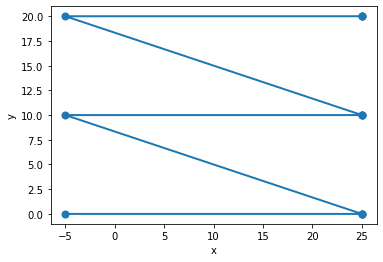

In [5]:
import matplotlib.pyplot as plt

bss.plot_raster_path(copys[1], "x", "y")
plt.show()

### Fly scan in rocking curves on a grid

A more complicated example is to move the sample in a grid and fly in the rotation.

In [6]:
plan = plans.fly_scan_nd(
    [detector], 
    motor_y, 0.0, 20.0, 3, 
    motor_x, 0.0, 20.0, 3,
    motor_phi, -1.5, 1.5, 3,
    move_velocity=10.0, 
    time_per_point=1.0,
    time_per_frame=1.0,
    shutter=shutter,
    shutter_open="open",
    shutter_close="close",
    shutter_wait_open=1.0,
    shutter_wait_close=5.0,
    take_dark=True,
    md={"sample": "A rod"}
)

The pseudo-code of it is shown below.

```
for y in 0, 10, 20:
    for x in 0, 10, 20:
        move to (x, y)
        close shutter
        wait 5 s
        take dark during the movement
        open shutter
        fly scan phi from -1.5 to 1.5, collect 3 images
```

We plot the trajectory in (x, y) plane. At each point, there is a fly scan in the phi axis.

*** all positions for phi_velocity are relative to current position ***


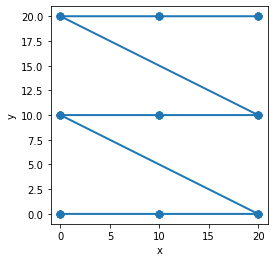

In [7]:
bss.plot_raster_path(plan, "x", "y")
plt.show()

## Grid scan

A grid scan is to move to a point in the motor positions space, stay there, collect one image at that point and then move to the next point and repeat.

Please read the document below about the syntax of the function.

In [8]:
help(plans.grid_scan_nd)

Help on function grid_scan_nd in module tomography.plans:

grid_scan_nd(detectors: list, *args, snake: Union[list, bool] = None, time_per_point: float, time_per_frame: float, shutter: object, shutter_open: Any, shutter_close: Any, shutter_wait_open: float = 0.0, shutter_wait_close: float = 0.0, take_dark: bool = True, md=None) -> <class 'Generic'>
    Scan over a mesh; each motor is on an independent trajectory.
    
    Parameters
    ----------
    detectors : list
        A list of 'readable' objects
    *args :
        patterned like (``motor1, start1, stop1, num1,``
                        ``motor2, start2, stop2, num2,``
                        ``motor3, start3, stop3, num3,`` ...
                        ``motorN, startN, stopN, numN``)
    
        The first motor is the "slowest", the outer loop. The last motor
        is the "fly" motor, the non-stoping scan along an axis. For all motors
        except the first motor, there is a "snake" argument: a boolean
        indicating 

## Grid scan in (x, y) plane

Below is an example to do grid scan in rows.

In [9]:
plan = plans.grid_scan_nd(
    [detector], 
    motor_y, 0.0, 20.0, 3, 
    motor_x, 0.0, 20.0, 3,
    time_per_point=1.0,
    time_per_frame=1.0,
    shutter=shutter,
    shutter_open="open",
    shutter_close="close",
    shutter_wait_open=1.0,
    shutter_wait_close=5.0,
    take_dark=True,
    md={"sample": "A rod"}
)

The pseudo-code of it can be expressed as below.

```
for y in 0, 10, 20:
    for x in 0, 10, 20:
        move to (x, y)
        if y moves in this step:
            close shutter
            wait 5 s
            take dark during the movement
            open shutter
        collect 1 image
```

We print out the details of the plans.

In [10]:
copys = it.tee(plan, 2)
bss.summarize_plan(copys[0])

image_cam_acquire_time -> 1.0
image_images_per_set -> 1
shutter -> open
=================================== Open Run ===================================
y -> 0.0
x -> 0.0
shutter -> close
  Read ['image']
shutter -> open
  Read ['image']
y -> 0.0
x -> 10.0
  Read ['image']
y -> 0.0
x -> 20.0
  Read ['image']
y -> 10.0
x -> 0.0
shutter -> close
  Read ['image']
shutter -> open
  Read ['image']
y -> 10.0
x -> 10.0
  Read ['image']
y -> 10.0
x -> 20.0
  Read ['image']
y -> 20.0
x -> 0.0
shutter -> close
  Read ['image']
shutter -> open
  Read ['image']
y -> 20.0
x -> 10.0
  Read ['image']
y -> 20.0
x -> 20.0
  Read ['image']
================================== Close Run ===================================
shutter -> close


We plot the trajectory of the stage.

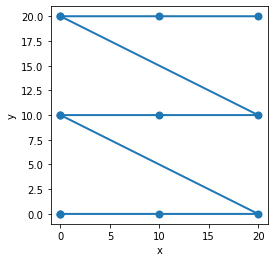

In [11]:
bss.plot_raster_path(copys[1], "x", "y")
plt.show()

### Grid scan in (phi, x, y) space

We can use arbitrary number of the motors in a grid scan. Here, we show an example to do a scan in a three dimensional space.

In [12]:
plan = plans.grid_scan_nd(
    [detector], 
    motor_y, 0.0, 20.0, 3, 
    motor_x, 0.0, 20.0, 3,
    motor_phi, -1, 1, 3,
    time_per_point=1.0,
    time_per_frame=1.0,
    shutter=shutter,
    shutter_open="open",
    shutter_close="close",
    shutter_wait_open=1.0,
    shutter_wait_close=5.0,
    take_dark=True,
    md={"sample": "A rod"}
)

The pseudo-code of it is described as below.

```
for y in 0, 10, 20:
    for x in 0, 10, 20:
        for phi in -1, 0, 1:
            move to (phi, x, y)
            if y moves in this step:
                close shutter
                wait 5 s
                take dark during the movement
                open shutter
            collect 1 image
```

The trajectory in (x, y) plane is shown below. At each (x, y) point, there is a scan at three points along phi axis.

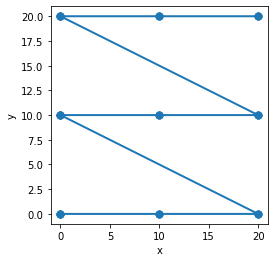

In [13]:
bss.plot_raster_path(plan, "x", "y")
plt.show()